In [ ]:
!pip install tensorflow opencv-python matplotlib --quiet
!pip install keras --quiet

In [ ]:
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from copy import deepcopy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access datasets

ROOT_DIR = '/content/drive/MyDrive/TicTacToe/data/images'  # Update with your folder path
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
input_shape = (32, 32, 1)  # Input image size for the model
batch_size = 32
epochs = 45


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))  # Resize to match the input shape
    img = np.expand_dims(img, axis=-1)
    return img.astype(np.float32)

def one_hot_encode(labels):
    mapper = {'blank': 0, 'nough': 1, 'circle': 2}  # Map labels
    encoded = [mapper[label] for label in labels]
    return to_categorical(encoded)

def load_data(root_dir, shuffle=True):
    X, y = [], []
    for root, dirs, files in os.walk(root_dir):
        for class_dir in dirs:
            image_dir = os.path.join(root_dir, class_dir)
            y.extend(np.tile(class_dir, len(os.listdir(image_dir))))
            for img_fn in os.listdir(image_dir):
                img = load_img(os.path.join(image_dir, img_fn))
                X.append(img)
    y = one_hot_encode(y)
    if shuffle:
        data = list(zip(X, y))
        np.random.shuffle(data)
        X, y = zip(*data)
    return np.asarray(X), np.asarray(y)

print('Loading data...')
X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR)
print(f'{len(X_train)} instances for training')
print(f'{len(X_test)} instances for evaluation')


Loading data...
494 instances for training
120 instances for evaluation


In [ ]:
train_val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1 / 255,
    validation_split=0.2)

train_generator = train_val_datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
val_generator = train_val_datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,435 (587.64 KB)

 Trainable params: 150,435 (587.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(patience=5, verbose=1, restore_best_weights=True)]

print('Training model...')
history = model.fit(
    train_generator,
    steps_per_epoch=128,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=32,
    callbacks=callbacks)

print('Evaluating model...')
test_datagen = ImageDataGenerator(rescale=1 / 255)
X_test, y_test = next(test_datagen.flow(X_test, y_test, batch_size=len(X_test)))

loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Crossentropy loss: {loss:.3f}')
print(f'Accuracy: {acc:.3f}')

model.save('/content/drive/MyDrive/TicTacToe/TicTacToe_model.h5')  # Save the trained model
print('Model saved to disk.')


Training model...
Epoch 1/45


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 12/128 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9779 - loss: 0.0874

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9888 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 2/45
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9842 - loss: 0.0541 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 3/45
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9802 - loss: 0.0625 - val_accuracy: 0.9898 - val_loss: 0.0304
Epoch 4/45
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9866 - loss: 0.0502 - val_accuracy: 1.0000 - val_loss: 0.0299
Epoch 5/45
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9794 - loss: 0.0576 - val_accuracy: 0.9898 - val_loss: 0.0566
Epoch 6/45
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9830 - loss: 0.0593 - val_accuracy: 0.9796 - val_loss: 0.0350
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Evaluating model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2906 - loss: 1.1260


Crossentropy loss: 1.111
Accuracy: 0.333
Model saved to disk.


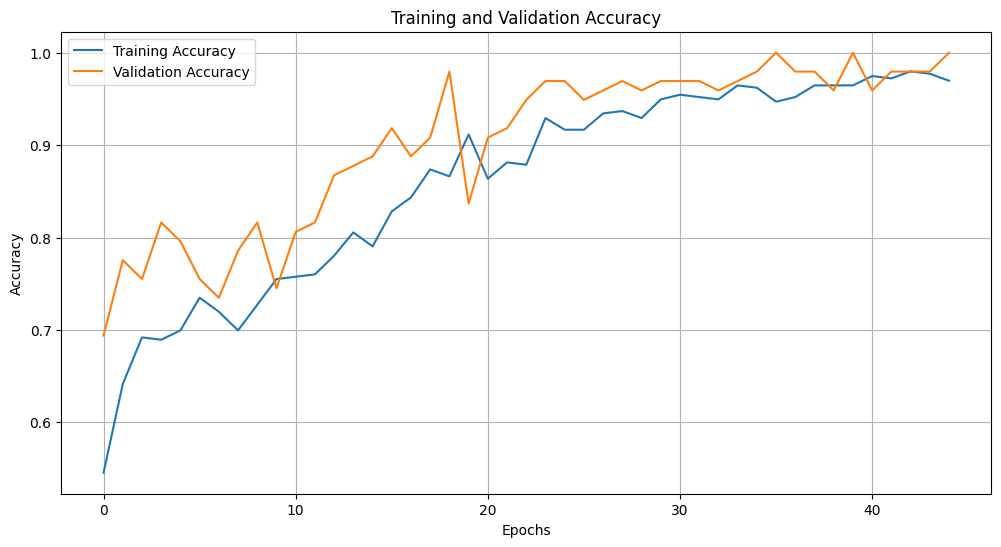

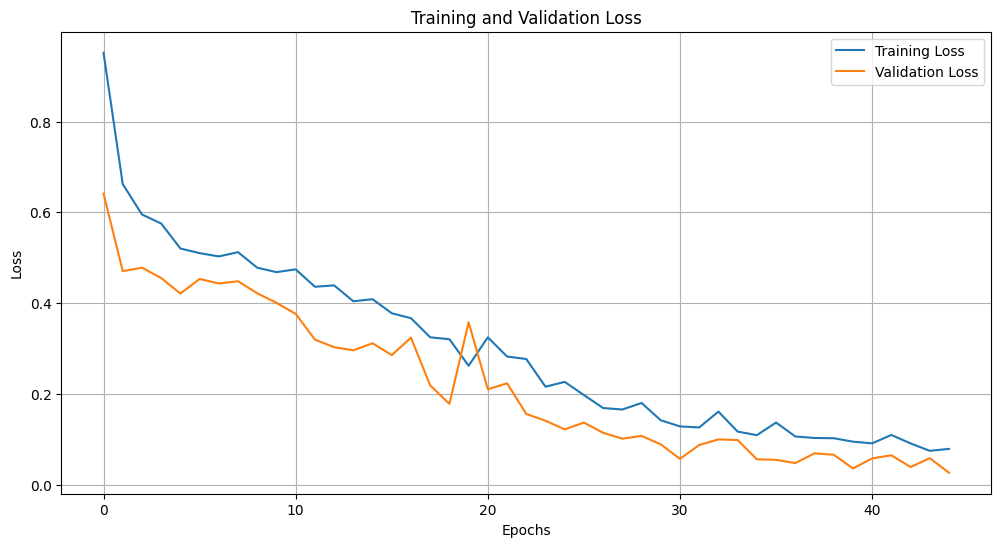

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9433 - loss: 0.3108
Test Accuracy: 0.942
Test Loss: 0.256
Training Error: 0.030
Great performance! The model generalizes well.


In [ ]:
import matplotlib.pyplot as plt

# Extracting history details from the training process
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate test performance
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")

# Calculate Training Error (final epoch loss)
training_error = 1 - history_dict['accuracy'][-1]
print(f"Training Error: {training_error:.3f}")

# Feedback:
if test_acc > 0.85:
    print("Great performance! The model generalizes well.")
elif test_acc > 0.70:
    print("Good performance, but there's room for improvement.")
else:
    print("The model is underperforming. Consider tuning hyperparameters or augmenting data.")


In [ ]:
def minimax(board, depth, is_maximizing):
    """
    Minimax algorithm to evaluate the best move for the current player.
    """
    scores = {'X': -10, 'O': 10, 'Tie': 0}

    result = check_winner(board)
    if result:
        return scores[result]

    if is_maximizing:
        best_score = -np.inf
        for move in get_available_moves(board):
            row, col = move
            board[row][col] = 'O'
            score = minimax(board, depth + 1, False)
            board[row][col] = ' '
            best_score = max(score, best_score)
        return best_score
    else:
        best_score = np.inf
        for move in get_available_moves(board):
            row, col = move
            board[row][col] = 'X'
            score = minimax(board, depth + 1, True)
            board[row][col] = ' '
            best_score = min(score, best_score)
        return best_score


def get_best_move(board):
    """
    Get the best move for 'O' using the minimax algorithm.
    """
    best_score = -np.inf
    move = None
    for m in get_available_moves(board):
        row, col = m
        board[row][col] = 'O'  # Simulate the move
        score = minimax(board, 0, False)
        board[row][col] = ' '  # Undo the move
        if score > best_score:
            best_score = score
            move = m
    return move


In [ ]:
def visualize_board(board):
    for row in board:
        print(' | '.join(row))
    print()

def predict_next_move(board):
    if not any('O' in row for row in board):  # Computer plays first
        board[1][1] = 'O'
    else:
        move = get_best_move(board)
        if move:
            board[move[0]][move[1]] = 'O'
    visualize_board(board)
    return board


In [ ]:
test_image_path = '/content/drive/MyDrive/TicTacToe/testimage12.jpeg'

# Verify file existence
if not os.path.exists(test_image_path):
    print(f"Error: File {test_image_path} does not exist.")
else:
    # Try reading the file
    img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Failed to read the image. Ensure it's a valid image.")
    else:
        print("Image loaded successfully. Proceeding to resize.")
        img = cv2.resize(img, (32, 32))
        print("Image resized successfully.")

Image loaded successfully. Proceeding to resize.
Image resized successfully.


In [ ]:
def preprocess_cell(cell):
    """
    Preprocess a cell image to improve model prediction accuracy.
    - Applies GaussianBlur, thresholding, and resizing.
    """
    # Denoise with GaussianBlur
    cell = cv2.GaussianBlur(cell, (5, 5), 0)

    # Binarize the image (thresholding)
    _, cell = cv2.threshold(cell, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize to model input size
    cell = cv2.resize(cell, (64, 64))

    return cell


In [ ]:
def initialize_board(img_path):
    """
    Initialize the Tic Tac Toe board from an input image.
    Trims 5% from each side of the cells for better predictions.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {img_path} could not be loaded.")

    # Resize the image for consistency
    img = cv2.resize(img, (300, 300))
    cell_size = img.shape[0] // 3  # Calculate size of each cell
    trim_percent = 0.05  # Percentage to trim from each side
    trim_pixels = int(cell_size * trim_percent)  # Convert percentage to pixels

    board = []

    for row in range(3):
        board_row = []
        for col in range(3):
            # Define the region for each cell
            x_start, x_end = col * cell_size, (col + 1) * cell_size
            y_start, y_end = row * cell_size, (row + 1) * cell_size

            # Extract and trim the cell
            cell = img[y_start:y_end,
                       x_start:x_end]
            cell = preprocess_cell(cell)

            # Debug: Show each trimmed cell
            plt.imshow(cell, cmap='gray')
            plt.title(f"Trimmed Cell ({row}, {col})")
            plt.show()

            # Preprocess the cell for model prediction
            cell = cv2.resize(cell, (32, 32))  # Resize to model input size
            cell = np.expand_dims(cell, axis=-1)  # Add channel dimension
            cell = cell.astype('float32') / 255.0  # Normalize

            # Predict the class (X, O, or None)
            prediction = model.predict(np.expand_dims(cell, axis=0))
            predicted_label = np.argmax(prediction)
            print(f"Prediction for Cell ({row}, {col}): {prediction}")
            print(f"Predicted Label: {predicted_label}")

            # # Add thresholding to refine predictions
            # confidence_threshold = 0.4  # Adjust based on analysis
            # confidence_threshold1 = 0.9
            # if confidence_threshold <= prediction[0][2] < 0.9:  # Probability for X
            #     board_row.append('X')
            # elif prediction[0][2] >= confidence_threshold1:  # Probability for O
            #     board_row.append('O')
            # else:
            #     board_row.append(' ')  # Blank

            # Map prediction to board symbols
            if predicted_label == 0:
                board_row.append(' ')  # Blank
            elif predicted_label == 1:
                board_row.append('X')  # Nough
            elif predicted_label == 2:
                board_row.append('O')  # Circle

        board.append(board_row)

    return board


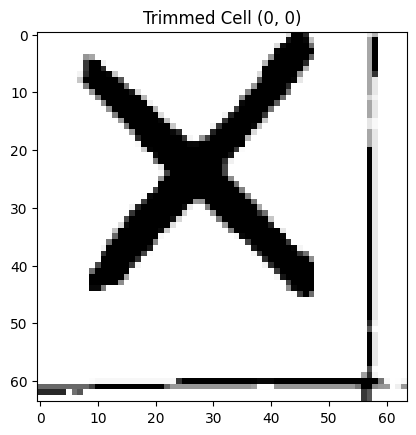

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for Cell (0, 0): [[1.2417903e-06 7.2023904e-01 2.7975976e-01]]
Predicted Label: 1


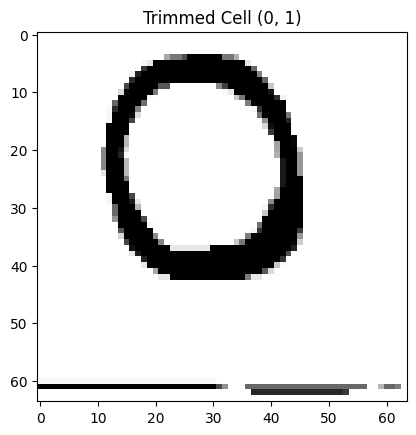

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for Cell (0, 1): [[0.00100867 0.28252935 0.71646196]]
Predicted Label: 2


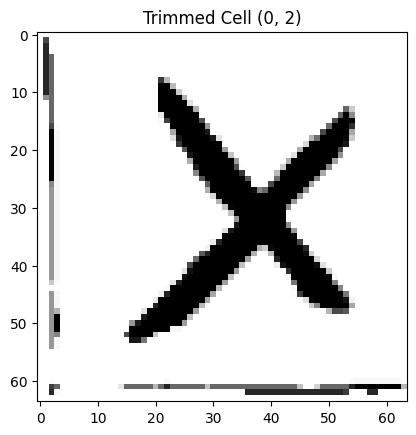

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for Cell (0, 2): [[1.2568848e-06 7.0953965e-01 2.9045901e-01]]
Predicted Label: 1


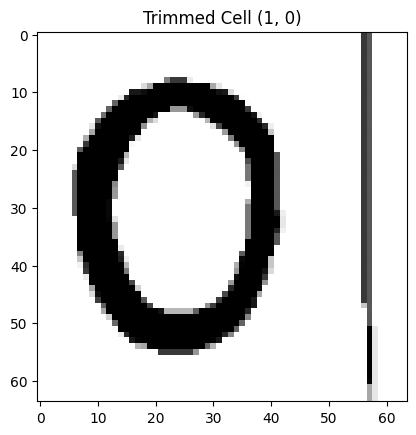

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for Cell (1, 0): [[5.601293e-04 7.250453e-02 9.269353e-01]]
Predicted Label: 2


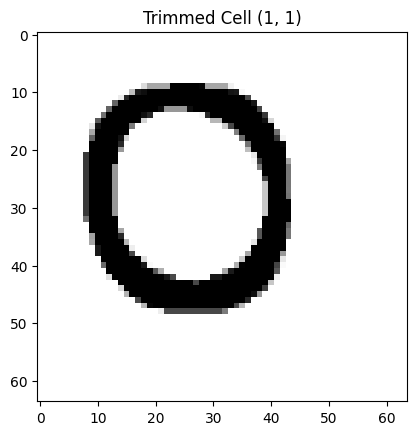

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for Cell (1, 1): [[1.4822680e-04 4.6702191e-02 9.5314956e-01]]
Predicted Label: 2


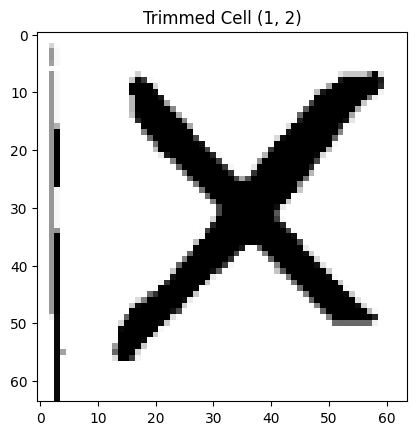

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for Cell (1, 2): [[3.3200383e-08 9.0169168e-01 9.8308377e-02]]
Predicted Label: 1


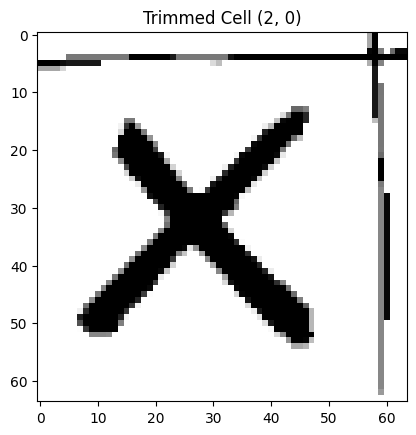

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for Cell (2, 0): [[8.1803258e-08 7.6330489e-01 2.3669504e-01]]
Predicted Label: 1


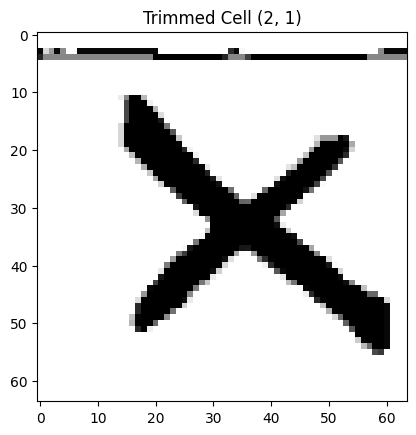

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for Cell (2, 1): [[1.2035754e-10 9.7652298e-01 2.3477007e-02]]
Predicted Label: 1


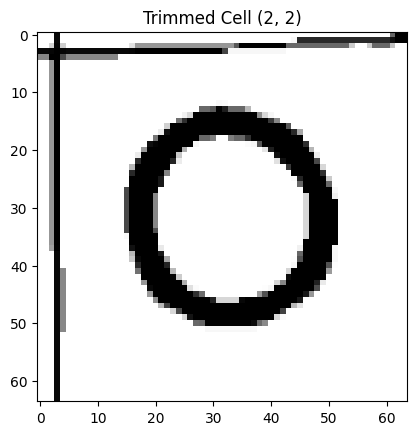

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for Cell (2, 2): [[3.7885275e-05 1.8634781e-02 9.8132735e-01]]
Predicted Label: 2
Initial Board State:
['X', 'O', 'X']
['O', 'O', 'X']
['X', 'X', 'O']


In [ ]:
test_image_path = '/content/drive/MyDrive/TicTacToe/gameplay35.jpeg'

# Initialize the game board from the image
try:
    board = initialize_board(test_image_path)
    print("Initial Board State:")
    for row in board:
        print(row)
except ValueError as e:
    print(e)


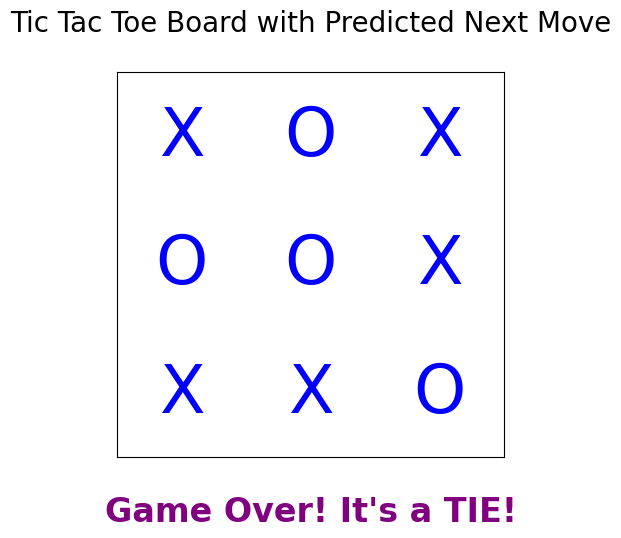

In [ ]:
def get_best_move(board):
    """
    Get the best move for 'O' using the minimax algorithm.
    """
    best_score = -np.inf
    move = None
    for m in get_available_moves(board):
        row, col = m
        board[row][col] = 'O'
        score = minimax(board, 0, False)
        board[row][col] = ' '
        if score > best_score:
            best_score = score
            move = m
    return move
def get_available_moves(board):
        """
        Get a list of available moves (empty cells) on the board.
        """
        moves = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == ' ':
                    moves.append((i, j))
        return moves

def check_winner(board):
        """
        Check for a winner in the Tic Tac Toe board.
        Returns 'X', 'O', or 'Tie' if there is a winner or tie, otherwise None.
        Also returns the winning line coordinates if applicable.
        """
        # Check rows
        for i in range(3):
            if board[i][0] == board[i][1] == board[i][2] and board[i][0] != ' ':
                return board[i][0], [(i, 0), (i, 1), (i, 2)]
        # Check columns
        for i in range(3):
            if board[0][i] == board[1][i] == board[2][i] and board[0][i] != ' ':
                return board[0][i], [(0, i), (1, i), (2, i)]
        # Check diagonals
        if board[0][0] == board[1][1] == board[2][2] and board[0][0] != ' ':
            return board[0][0], [(0, 0), (1, 1), (2, 2)]
        if board[0][2] == board[1][1] == board[2][0] and board[0][2] != ' ':
            return board[0][2], [(0, 2), (1, 1), (2, 0)]
        # Check for a tie
        if all(board[i][j] != ' ' for i in range(3) for j in range(3)):
            return 'Tie', []
        return None, []

def minimax(board, depth, is_maximizing):
        """
        Minimax algorithm to evaluate the best move for the current player.
        """
        scores = {'X': -10, 'O': 10, 'Tie': 0}

        result, _ = check_winner(board)
        if result:
            return scores[result]

        if is_maximizing:
            best_score = -np.inf
            for move in get_available_moves(board):
                row, col = move
                board[row][col] = 'O'
                score = minimax(board, depth + 1, False)
                board[row][col] = ' '
                best_score = max(score, best_score)
            return best_score
        else:
            best_score = np.inf
            for move in get_available_moves(board):
                row, col = move
                board[row][col] = 'X'
                score = minimax(board, depth + 1, True)
                board[row][col] = ' '
                best_score = min(score, best_score)
            return best_score

def visualize_board_with_next_move(board):
    """
    Visualize the Tic Tac Toe board with borders, highlight the predicted next move for 'O',
    and mark the winning row, column, or diagonal in red if applicable.
    """
    # Predict the next move for 'O'
    next_move = get_best_move(board)
    if next_move:
        row, col = next_move
        board[row][col] = 'O'

    # Check for a winner after making the next move
    winner, winning_line = check_winner(board)

    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjusted figure size for compactness
    ax.set_xlim(-0.5, 2.5)  # Set limits for the x-axis
    ax.set_ylim(-0.5, 2.5)  # Set limits for the y-axis
    ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=2)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Draw the grid and board pieces
    for i in range(3):
        for j in range(3):
            cell_value = board[i][j]
            ax.text(j, 2 - i, cell_value, ha='center', va='center', fontsize=48, color='blue')  # Adjusted font size
            if next_move == (i, j):
                ax.text(j, 2 - i, 'O', ha='center', va='center', fontsize=48, color='green')  # Adjusted font size


    # Mark the winning line if there's a winner
    if winner and winner != 'Tie':
        x_coords = [coord[1] for coord in winning_line]
        y_coords = [2 - coord[0] for coord in winning_line]
        ax.plot(x_coords, y_coords, color='red', linewidth=4)

    # Display the board
    plt.title("Tic Tac Toe Board with Predicted Next Move\n", fontsize=20)

    # Print game status
    status_message = ""
    color = 'black'
    if winner:
        if winner == 'Tie':
            status_message = "Game Over! It's a TIE!"
            color = 'purple'
        else:
            status_message = f"Game Over! {winner} WINS!"
            color = 'green' if winner == 'O' else 'red'
    else:
        status_message = "Game in Progress. No Winner Yet."
        color = 'blue'

    # Display the status message below the board in large font
    plt.text(1, -1, status_message, ha='center', fontsize=24, color=color, weight='bold')
    plt.show()
visualize_board_with_next_move(board)

In [ ]:
print(f"Sample Predictions on Training Data:")
for i in range(5):
    sample = X_train[i]
    plt.imshow(sample.reshape(32, 32), cmap='gray')
    plt.title(f"True Label: {np.argmax(y_train[i])}")
    plt.show()
    pred = model.predict(np.expand_dims(sample, axis=0))
    print(f"Predicted Label: {np.argmax(pred)}")
